<img src=docs/tudelft_logo.jpg width=50%>

## Data-driven Design and Analyses of Structures and Materials (3dasm)

## Lecture 6

### Miguel A. Bessa | <a href = "mailto: M.A.Bessa@tudelft.nl">M.A.Bessa@tudelft.nl</a>  | Associate Professor

**What:** A lecture of the "3dasm" course

**Where:** This notebook comes from this [repository](https://github.com/bessagroup/3dasm_course)

**Reference for entire course:** Murphy, Kevin P. *Probabilistic machine learning: an introduction*. MIT press, 2022. Available online [here](https://probml.github.io/pml-book/book1.html)

**How:** We try to follow Murphy's book closely, but the sequence of Chapters and Sections is different. The intention is to use notebooks as an introduction to the topic and Murphy's book as a resource.
* If working offline: Go through this notebook and read the book.
* If attending class in person: listen to me (!) but also go through the notebook in your laptop at the same time. Read the book.
* If attending lectures remotely: listen to me (!) via Zoom and (ideally) use two screens where you have the notebook open in 1 screen and you see the lectures on the other. Read the book.

**Optional reference (the "bible" by the "bishop"... pun intended 😆) :** Bishop, Christopher M. *Pattern recognition and machine learning*. Springer Verlag, 2006.

**References/resources to create this notebook:**
* [Car figure](https://korkortonline.se/en/theory/reaction-braking-stopping/)

Apologies in advance if I missed some reference used in this notebook. Please contact me if that is the case, and I will gladly include it here.

## **OPTION 1**. Run this notebook **locally in your computer**:
1. Confirm that you have the 3dasm conda environment (see Lecture 1).

2. Go to the 3dasm_course folder in your computer and pull the last updates of the [repository](https://github.com/bessagroup/3dasm_course):
```
git pull
```
3. Open command window and load jupyter notebook (it will open in your internet browser):
```
conda activate 3dasm
jupyter notebook
```
4. Open notebook of this Lecture.

## **OPTION 2**. Use **Google's Colab** (no installation required, but times out if idle):

1. go to https://colab.research.google.com
2. login
3. File > Open notebook
4. click on Github (no need to login or authorize anything)
5. paste the git link: https://github.com/bessagroup/3dasm_course
6. click search and then click on the notebook for this Lecture.

In [1]:
# Basic plotting tools needed in Python.

import matplotlib.pyplot as plt # import plotting tools to create figures
import numpy as np # import numpy to handle a lot of things!
from IPython.display import display, Math # to print with Latex math

%config InlineBackend.figure_format = "retina" # render higher resolution images in the notebook
plt.style.use("seaborn") # style for plotting that comes from seaborn
plt.rcParams["figure.figsize"] = (8,4) # rescale figure size appropriately for slides

## Outline for today

* Continuation of previous lecture: Bayesian inference for one hidden rv
    - Prior
    - Likelihood
    - Marginal likelihood
    - Posterior
    - Gaussian pdf's product

**Reading material**: This notebook + Chapter 3

## Recap of Lecture 5: car stopping distance with known $x$ and $p(z_2)$

We focused on the car stopping distance problem with two rv's under the following conditions:
* We kept $x=75$ m/s.
* The "true" distribution of one of the rv's  was known: $p(z_2)=\mathcal{N}(\mu_{z_2}=0.1,\sigma_{z_2}^2=0.01^2)$
* But the distribution of the other rv ($z \equiv z_1$) is not known: $p(z)=?$

Under these conditions, recall the "true" model by observing the following plot, including some data observations.

In [2]:
# This cell is hidden during presentation. It's just to define a function to plot the governing model of
# the car stopping distance problem. Defining a function that creates a plot allows to repeatedly run
# this function on cells used in this notebook.
def car_fig_2rvs(ax):
    x = np.linspace(3, 83, 1000)
    mu_z1 = 1.5; sigma_z1 = 0.5;  # parameters of the "true" p(z_1)
    mu_z2 = 0.1; sigma_z2 = 0.01; # parameters of the "true" p(z_2)
    mu_y = mu_z1*x + mu_z2*x**2 # From Homework of Lecture 4
    sigma_y = np.sqrt( (x*sigma_z1)**2 + (x**2*sigma_z2)**2 ) # From Homework of Lecture 4
    ax.set_xlabel("x (m/s)", fontsize=20) # create x-axis label with font size 20
    ax.set_ylabel("y (m)", fontsize=20) # create y-axis label with font size 20
    ax.set_title("Car stopping distance problem with two rv's", fontsize=20); # create title with font size 20
    ax.plot(x, mu_y, 'k:', label="Governing model $\mu_y$")
    ax.fill_between(x, mu_y - 1.9600 * sigma_y,
                    mu_y + 1.9600 * sigma_y,
                    color='k', alpha=0.2,
                    label='95% confidence interval ($\mu_y \pm 1.96\sigma_y$)') # plot 95% credence interval
    ax.legend(fontsize=15)

In [3]:
# This cell is also hidden during presentation.
from scipy.stats import norm # import the normal dist, as we learned before!
def samples_y_with_2rvs(N_samples,x): # observations/measurements/samples for car stop. dist. prob. with 2 rv's
    mu_z1 = 1.5; sigma_z1 = 0.5;
    mu_z2 = 0.1; sigma_z2 = 0.01;
    samples_z1 = norm.rvs(mu_z1, sigma_z1, size=N_samples) # randomly draw samples from the normal dist.
    samples_z2 = norm.rvs(mu_z2, sigma_z2, size=N_samples) # randomly draw samples from the normal dist.
    samples_y = samples_z1*x + samples_z2*x**2 # compute the stopping distance for samples of z_1 and z_2
    return samples_y # return samples of y

Empirical mean[y] is 656.9136480037533 (real mean[y]=675)
Empirical std[y] is 20.3661958539267 (real std[y]=67.6)


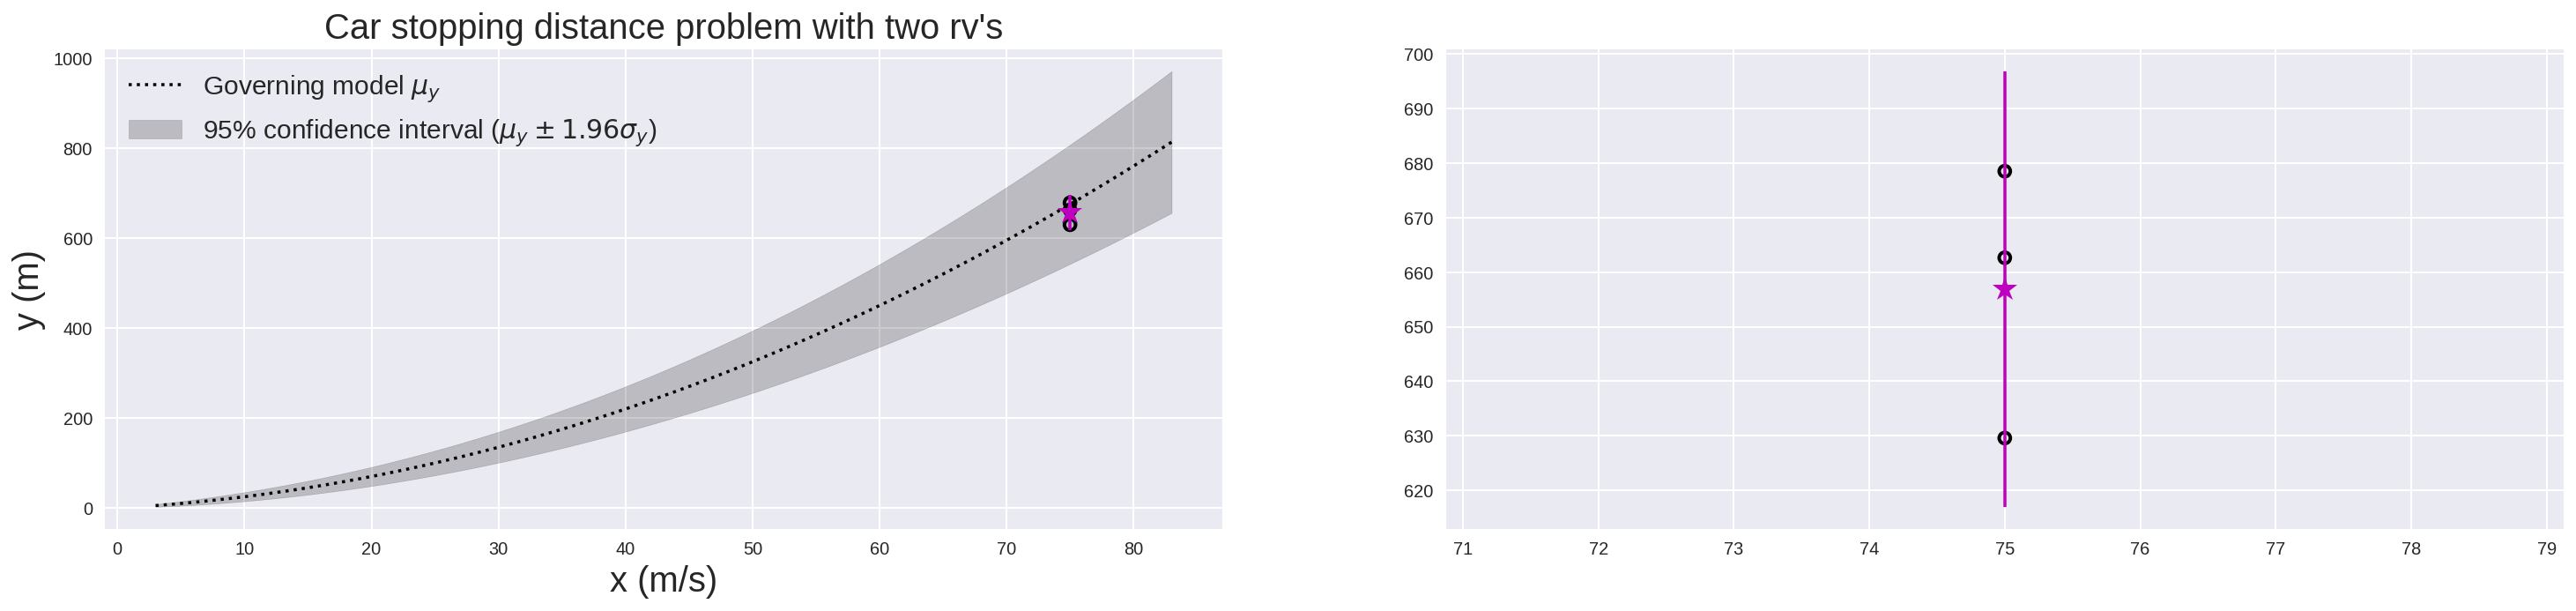

In [4]:
# vvvvvvvvvvv this is just a trick so that we can run this cell multiple times vvvvvvvvvvv
fig_car_new, ax_car_new = plt.subplots(1,2); plt.close() # create figure and close it
if fig_car_new.get_axes():
    del ax_car_new; del fig_car_new # delete figure and axes if they exist
    fig_car_new, ax_car_new = plt.subplots(1,2) # create them again
# ^^^^^^^^^^^ end of the trick ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
N_samples = 3 # CHANGE THIS NUMBER AND RE-RUN THE CELL
x = 75; empirical_y = samples_y_with_2rvs(N_samples, x); # Empirical measurements of N_samples at x=75
empirical_mu_y = np.mean(empirical_y); empirical_sigma_y = np.std(empirical_y); # empirical mean and std
car_fig_2rvs(ax_car_new[0]) # a function I created to include the background plot of the governing model
for i in range(2): # create two plots (one is zooming in on the error bar)
    ax_car_new[i].errorbar(x , empirical_mu_y,yerr=1.96*empirical_sigma_y, fmt='m*', markersize=15);
    ax_car_new[i].scatter(x*np.ones_like(empirical_y),empirical_y, s=40,
                          facecolors='none', edgecolors='k', linewidths=2.0)
print("Empirical mean[y] is",empirical_mu_y, "(real mean[y]=675)")
print("Empirical std[y] is",empirical_sigma_y,"(real std[y]=67.6)")
fig_car_new.set_size_inches(25, 5) # scale figure to be wider (since there are 2 subplots)

## Recap of Lecture 5: Summary of our model

1. The **observation distribution**:

$$
p(y|z) = \mathcal{N}\left(y | \mu_{y|z}=w z+b, \sigma_{y|z}^2\right) = \frac{1}{C_{y|z}} \exp\left[ -\frac{1}{2\sigma_{y|z}^2}(y-\mu_{y|z})^2\right]
$$

where $C_{y|z} = \sqrt{2\pi \sigma_{y|z}^2}$ is the **normalization constant** of the Gaussian pdf, and where $\mu_{y|z}=w z+b$, with $w$, $b$ and $\sigma_{y|z}^2$ being constants.

2. and the **prior distribution**: $p(z) = \frac{1}{C_z}$

where $C_z = z_{max}-z_{min}$ is the **normalization constant** of the Uniform pdf, i.e. the value that guarantees that $p(z)$ integrates to one.

### Recap of Lecture 5: Data

* Since we usually don't know the true process, we can only observe/collect data $y=\mathcal{D}_y$:

In [5]:
print("Example of N=%1i data points for y at x=%1.1f m/s with :" % (N_samples,x), empirical_y)

Example of N=3 data points for y at x=75.0 m/s with : [678.49613884 629.60513988 662.63966529]


## Recap of Lecture 5: Posterior from Bayes' rule applied to data

Use Bayes' rule applied to data to determine the <font color='green'>posterior</font>:

$\require{color}$
$$
{\color{green}p(z|y=\mathcal{D}_y)} = \frac{ {\color{blue}p(y=\mathcal{D}_y|z)}{\color{red}p(z)} } {p(y=\mathcal{D}_y)}
$$

That requires calculating the <font color='blue'>likelihood</font> (here, it results from a product of Gaussian densities):

$$
{\color{blue}p(y=\mathcal{D}_y | z)} = \frac{1}{|w|^N} \cdot C \cdot \frac{1}{\sqrt{2\pi \sigma^2}} \exp\left[ -\frac{1}{2\sigma^2}(z-\mu)^2\right]
$$

where $\mu = \frac{w^2\sigma^2}{\sigma_{y|z}^2} \sum_{i=1}^N \mu_i$

$\sigma^2 = \frac{\sigma_{y|z}^2}{w^2 N}$, and

$C = \frac{1}{2\pi^{(N-1)/2}} \sqrt{\frac{\sigma^2}{\left( \frac{\sigma_{y|z}^2}{w^2}\right)^N}} \exp\left[-\frac{1}{2}\left(\frac{w^2}{\sigma_{y|z}^2}\sum_{i=1}^N \mu_i - \frac{\mu^2}{\sigma^2}\right) \right]
$

After calculating the likelihood, we determined the marginal likelihood:

$$
p(y=\mathcal{D}_y) = \frac{C}{|w|^N C_z}
$$

From which we got the <font color='green'>posterior</font>:

$$\require{color}\begin{align}
{\color{green}p(z|y=\mathcal{D}_y)} &= \frac{ p(y=\mathcal{D}_y|z)p(z) } {p(y=\mathcal{D}_y)} \\
&= \frac{1}{p(y=\mathcal{D}_y)} \cdot \frac{1}{|w|^N} C \cdot \mathcal{N}(z|\mu,\sigma^2) \cdot \frac{1}{C_z} \\
&= \mathcal{N}(z|\mu, \sigma^2)
\end{align}
$$

which is a **normalized** Gaussian pdf in $z$ with mean and variance as shown in the previous cell.

## Determining the Posterior Predictive Distribution (<a title="Posterior Predictive Distribution">PPD</a>) from the posterior

However, as we mentioned, Bayes' rule is just a way to calculate the posterior:

$$
p(z|y=\mathcal{D}_y) = \frac{ p(y=\mathcal{D}_y|z)p(z) } {p(y=\mathcal{D}_y)}
$$

What we really want is the <font color='orange'>Posterior Predictive Distribution (<a title="Posterior Predictive Distribution">PPD</a>)</font> . This comes after calculating the posterior given some data $\mathcal{D}_y$:

$$\require{color}
{\color{orange}p(y|y=\mathcal{D}_y)} = \int p(y|z) p(z|y=\mathcal{D}_y) dz
$$

which is often written in simpler notation: $p(y|\mathcal{D}_y) = \int p(y|z) p(z|\mathcal{D}_y) dz$

$$\require{color}
{\color{orange}p(y|\mathcal{D}_y)} = \int \underbrace{p(y|z)}_{\text{observation}\\ \text{distribution}} \overbrace{p(z|y=\mathcal{D}_y)}^{\text{posterior}} dz
$$

Considering the terms we found before, we get:

$$\begin{align}
p(y|\mathcal{D}_y) &= \int \underbrace{\frac{1}{|w|}\frac{1}{\sqrt{2\pi \left(\frac{\sigma_{y|z}}{w}\right)^2}} \exp\left\{ -\frac{1}{2\left(\frac{\sigma_{y|z}}{w}\right)^2}\left[z-\left(\frac{y-b}{w}\right)\right]^2\right\} }_{\text{observation}\\ \text{distribution}} \overbrace{\mathcal{N}(z|\mu, \sigma^2)}^{\text{posterior}} dz
\end{align}
$$

$$\require{color}
{\color{orange}p(y|\mathcal{D}_y)} = \frac{1}{|w|} \int {\color{blue}\frac{1}{\sqrt{2\pi \left(\frac{\sigma_{y|z}}{w}\right)^2}} \exp\left\{ -\frac{1}{2\left(\frac{\sigma_{y|z}}{w}\right)^2}\left[z-\left(\frac{y-b}{w}\right)\right]^2\right\}} \mathcal{N}(z|\mu, \sigma^2) dz
$$

$$\require{color}
{\color{orange}p(y|\mathcal{D}_y)} = \frac{1}{|w|} \int \mathcal{N}\left(z\left|\frac{y-b}{w}, \left(\frac{\sigma_{y|z}}{w}\right)^2\right.\right) \mathcal{N}(z|\mu, \sigma^2) dz
$$

This is (again!) the product of two Gaussians!

In Lecture 5 (and the Homework!) you saw (and demonstrated!) that the product of two or more univariate (and multivariate!) Gaussians is...

* Another Gaussian! Although it needs to be scaled by a constant...

So, we conclude that the <a title="Posterior Predictive Distribution">PPD</a> is an integral of a Gaussian:

$$\require{color}
{\color{orange}p(y|\mathcal{D}_y)} = \frac{1}{|w|} \int  C^* \mathcal{N}\left(z|\mu^*, \left(\sigma^*\right)^2\right) dz
$$


where $\mu^* = \left(\sigma^* \right)^2 \left( \frac{\mu}{\sigma^2} + \frac{(y-b)/w}{\left(\frac{\sigma_{y|z}}{w}\right)^2} \right) = \left(\sigma^* \right)^2 \left( \frac{\mu}{\sigma^2} + \frac{(y-b)\cdot w}{\sigma_{y|z}^2} \right)$

$\left( \sigma^* \right)^2 = \frac{1}{\frac{1}{\sigma^2}+\frac{1}{\left( \frac{\sigma_{y|z}}{w}\right)^2}}= \frac{1}{\frac{1}{\sigma^2}+\frac{w^2}{\sigma_{y|z}^2}}$

$C^* = \frac{1}{\sqrt{2\pi \left( \sigma^2 + \frac{\sigma_{y|z}^2}{w^2} \right)}}\exp\left[ - \frac{\left(\mu - \frac{y-b}{w}\right)^2}{2\left( \sigma^2+\frac{\sigma_{y|z}^2}{w^2}\right)}\right]$

This integral is simple to solve!

$$\require{color}
\begin{align}
{\color{orange}p(y|\mathcal{D}_y)} &= \frac{1}{|w|} \int  C^* \mathcal{N}\left(z|\mu^*, \left(\sigma^*\right)^2\right) dz \\
&= \frac{C^*}{|w|} \int   {\color{blue}\mathcal{N}\left(z|\mu^*, \left(\sigma^*\right)^2\right)} dz
\end{align}
$$

What's the result of integrating the <font color='blue'>blue</font> term?

$$\require{color}
{\color{orange}p(y|\mathcal{D}_y)} = \frac{C^*}{|w|}
$$

## Exercise 1

Rewrite the <a title="Posterior Predictive Distribution">PPD</a> to show that it becomes:

$$\require{color}
{\color{orange}p(y|\mathcal{D}_y)} = \mathcal{N}\left(y| b+\mu w, w^2\sigma^2+\sigma_{y|z}^2 \right)
$$

a normalized univariate Gaussian!

## A long way to show that the <a title="Posterior Predictive Distribution">PPD</a> is a simple Gaussian...

$$\require{color}
{\color{orange}p(y|\mathcal{D}_y)} = \mathcal{N}\left(y| b+\mu w, w^2\sigma^2+\sigma_{y|z}^2 \right)
$$

where we recall that each constant is:

$b = 0.1x^2 = 562.5$

$w = x = 75$

$\sigma_{y|z}^2 = (x^2 \sigma_{z_2})^2=(75^2\cdot0.01)^2=56.25^2$

$\sigma^2 = \frac{\sigma_{y|z}^2}{w^2 N} = \frac{(x^2\cdot\sigma_{z_2})^2}{x^2 N} = \frac{x^2\cdot\sigma_{z_2}^2}{N} $

$\mu = \frac{w^2 \sigma^2}{\sigma_{y|z}^2} \sum_{i=1}^{N} \mu_i = \cdots = \frac{\sum_{i=1}^N y_i}{w N}-\frac{b}{w}$


#### Note on algebra to determine $\mu$ parameter:

$$
\begin{align}
\mu &= \frac{w^2 \sigma^2}{\sigma_{y|z}^2} \sum_{i=1}^{N} \mu_i \\
&= \frac{\sum_{i=1}^{N} \mu_i}{N} = \frac{1}{N} \sum_{i=1}^{N} \left(\frac{y_i-b}{w}\right) \\
&= \frac{1}{w N} \sum_{i=1}^N\left( y_i-b\right) \\
&= \frac{1}{w N} \left( \sum_{i=1}^N y_i-N b\right) \\
& = \frac{\sum_{i=1}^N y_i}{w N}-\frac{b}{w}
\end{align}
$$

## A long way to show that the <a title="Posterior Predictive Distribution">PPD</a> is a simple Gaussian...

$$\require{color}
\begin{align}
{\color{orange}p(y|\mathcal{D}_y)} &= \mathcal{N}\left(y| b+\mu w, w^2\sigma^2+\sigma_{y|z}^2 \right) \\
&= \mathcal{N}\left(y \left| \left(\sum_{i=1}^N \frac{y_i}{N}\right), \sigma_{y|z}^2 \left(\frac{1}{N} + 1 \right) \right. \right)
\end{align}
$$

where $y_i$ are each of the $N$ data points of the observed data $\mathcal{D}_y$, and $\sigma_{y|z}^2 = (x^2 \sigma_{z_2})^2=(75^2\cdot0.01)^2=56.25^2$ is the variance arising from the contribution of $z_2$ on $y$.

* **Very Important Questions (VIQs)**: What does this result tell us? Did you expect this predicted distribution for $y$?

PPD & empirical mean[y] are the same: 701.3515506381136 (real mean[y]=675)
PPD std[y] is 64.9519052838329 & empirical std[y] is 41.80014207287238 (real std[y]=67.6)


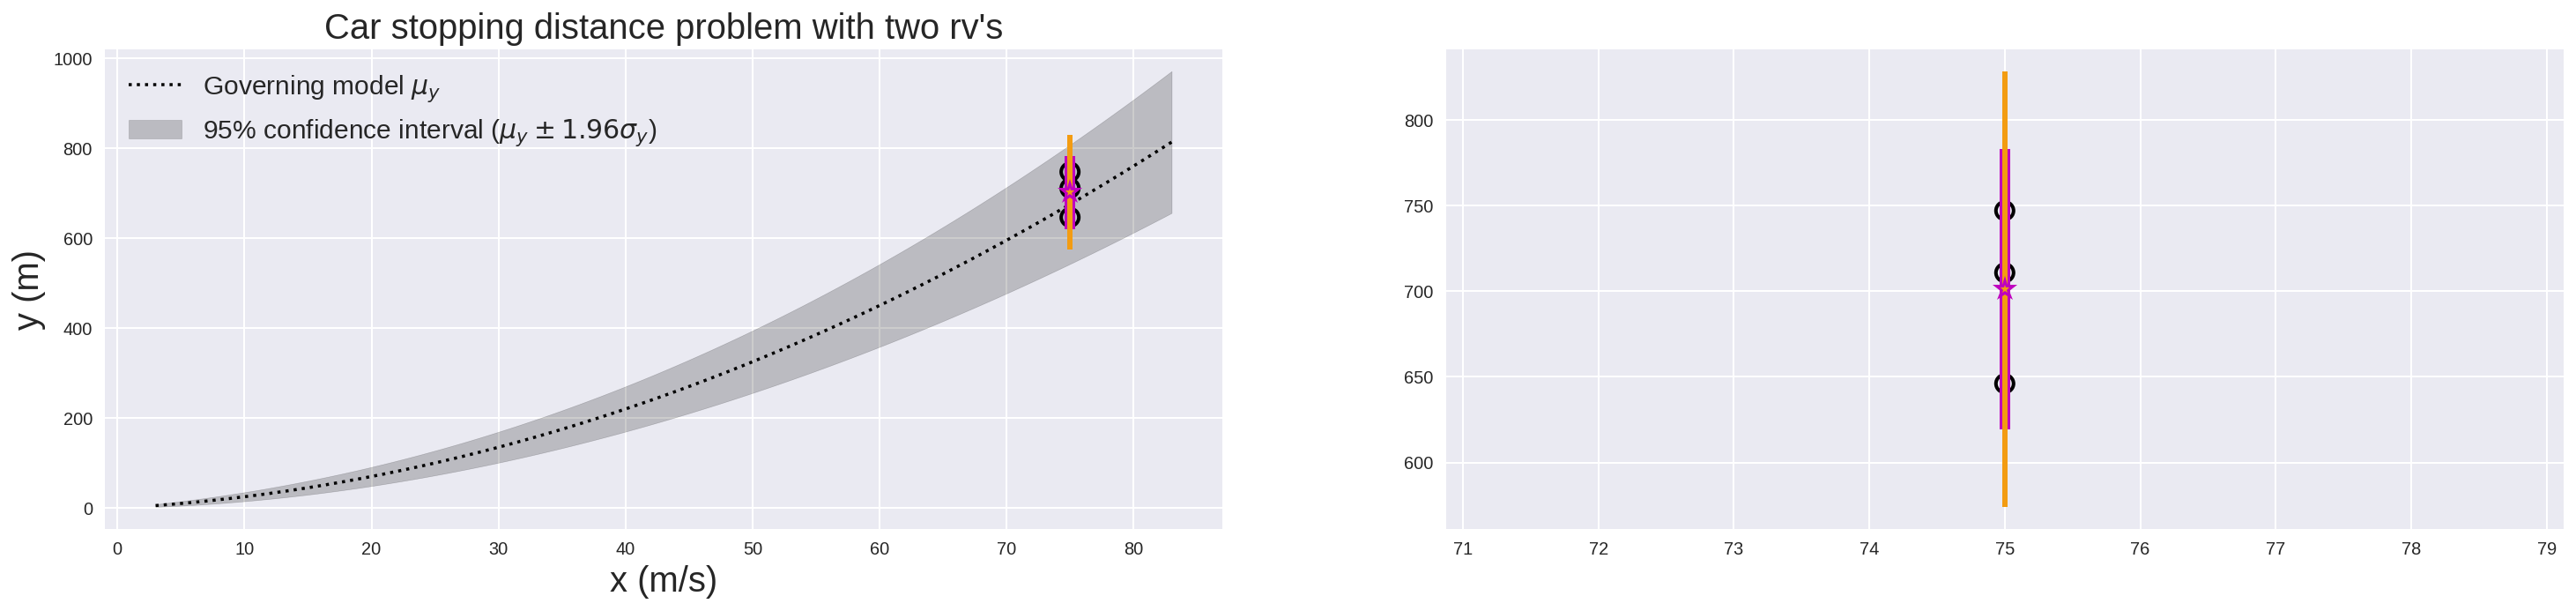

In [6]:
fig_car_PPD, ax_car_PPD = plt.subplots(1,2); plt.close() # create figure and close it
if fig_car_new.get_axes():
    del ax_car_PPD; del fig_car_PPD; fig_car_PPD, ax_car_PPD = plt.subplots(1,2) # delete fig & axes & create them
N_samples = 3 # CHANGE THIS NUMBER AND RE-RUN THE CELL
x = 75; empirical_y = samples_y_with_2rvs(N_samples, x); # Empirical measurements of N_samples at x=75
empirical_mu_y = np.mean(empirical_y); empirical_sigma_y = np.std(empirical_y); # empirical mean and std
# Calculate PPD mean and standard deviation:
PPD_mu_y = np.mean(empirical_y); sigma_z2 = 0.01; PPD_sigma_y = np.sqrt( (x**2*sigma_z2)**2*(1/N_samples + 1) )
car_fig_2rvs(ax_car_PPD[0]) # a function I created to include the background plot of the governing model
for i in range(2): # create two plots (one is zooming in on the error bar)
    ax_car_PPD[i].errorbar(x , empirical_mu_y,yerr=1.96*empirical_sigma_y, fmt='m*', markersize=15, elinewidth=6);
    ax_car_PPD[i].errorbar(x , PPD_mu_y,yerr=1.96*PPD_sigma_y, color='#F39C12', fmt='*', markersize=5, elinewidth=3);
    ax_car_PPD[i].scatter(x*np.ones_like(empirical_y),empirical_y, s=100,facecolors='none', edgecolors='k', linewidths=2.0)
print("PPD & empirical mean[y] are the same:",empirical_mu_y, "(real mean[y]=675)")
print("PPD std[y] is",PPD_sigma_y, "& empirical std[y] is",empirical_sigma_y,"(real std[y]=67.6)")
fig_car_PPD.set_size_inches(25, 5) # scale figure to be wider (since there are 2 subplots)

### Reflection on what we are observing

1. Generally speaking, our PPD is quite reasonable!
    * For few data points it is more reasonable than just calculating the standard deviation directly from the data.

2. However, as the number of data points increases it starts getting "overconfident" (see PPD as $N\rightarrow \infty$ or play with the figure above by increasing $N$).
    * This results from our choice of prior... Our belief was incorrect.
        * The hidden rv $z$ is actually a Gaussian distribution, instead of a noninformative Uniform distribution

Please keep this in your head:
* (Bayesian) ML is not magic. Every modeling choice you make affects the predictions you get.
* Of course, there are ways of getting "closer" to the truth! We'll take some steps in that direction in the remainder of the course. 

# <font color='red'>HOMEWORK</font>

Consider the same problem, but now starting from a different model:

1. Same **observation distribution** as before:

$$
p(y|z) = \mathcal{N}\left(y | \mu_{y|z}=w z+b, \sigma_{y|z}^2\right) = \frac{1}{C_{y|z}} \exp\left[ -\frac{1}{2\sigma_{y|z}^2}(y-\mu_{y|z})^2\right]
$$

2. <font color='blue'>but now assuming a different **prior distribution**</font>: $p(z) = \mathcal{N}\left(z| \overset{\scriptscriptstyle <}{\mu}_z=3, \overset{\scriptscriptstyle <}{\sigma}_z^2=2^2
\right)$

In my notation, the superscript $\overset{\scriptscriptstyle <}{(\cdot)}$ indicates a parameter of the prior distribution.

### Notes about the prior distribution

* We would have to be very lucky if our "belief" coincided with the "true" distribution of $z$.
    * Usually, we have beliefs but they are not really true (not talking about religion 😆).
        - Our hope is that our beliefs are at least reasonable!

* When defining a prior we are making a decision about two things:
    1. The distribution.
        * For example, in this exercise we are assuming that the prior is Gaussian (before we assumed a noninformative Uniform prior). In this case we hit the jackpot! But remember that we are cheating here... That's why we know the actual distribution of $z$ is a Gaussian!
    2. The parameters of the distribution.
        * For example, in this exercise we are assuming values that are not the true ones! This is normal! As I said, usually we don't know the truth about the "hidden" variable. Most times we don't even know how  many hidden variables we have...

### See you next class

Have fun!